# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import random
import copy
from random import sample 
import json

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, random_split
from torch.nn import functional as F
from torch.optim import lr_scheduler

os.getcwd()

'/Users/veershah/Desktop/covid-mrna-degradation/inference'

# Settings

In [2]:
class config:
    train_file = '/Users/veershah/Desktop/covid-mrna-degradation/data/train.json'
    test_file = '/Users/veershah/Desktop/covid-mrna-degradation/data/test.json'
    pretrain_dir = './'
    sample_submission = '/Users/veershah/Desktop/covid-mrna-degradation/data/sample_submission.csv'
    learning_rate = 0.001
    batch_size = 64
    n_epoch = 200
    n_split = 5
    K = 1 # number of aggregation loop (also means number of GCN layers)
    gcn_agg = 'mean' # aggregator function: mean, conv, lstm, pooling
    filter_noise = True
    patience= 15
    seed = 1234
    loss_weights = torch.tensor([0.3,0.3,0.05,0.3,0.05])

# Load Data

In [3]:
pred_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [4]:
token2int = {x:i for i, x in enumerate('().ACGUBEHIMSX')}
dict_token = [(0, '.'), (1, '('), (2, '0'), (3, 'A'), (4, 'C'), (5, 'G'), (6, 'U'), (7, 'B'), (8, 'E'), (9, 'H'), (10, 'I'), (11, 'M'), (12, 'S'), (13, 'X')]
int2token = {i:x for x, i in dict_token}

def get_couples(structure):
    """
    For each closing parenthesis, I find the matching opening one and store their index in the couples list.
    The assigned list is used to keep track of the assigned opening parenthesis
    """
    opened = [idx for idx, i in enumerate(structure) if i == '(']
    closed = [idx for idx, i in enumerate(structure) if i == ')']

    assert len(opened) == len(closed)
    assigned = []
    couples = []

    for close_idx in closed:
        for open_idx in opened:
            if open_idx < close_idx:
                if open_idx not in assigned:
                    candidate = open_idx
            else:
                break
        assigned.append(candidate)
        couples.append([candidate, close_idx])
        
    assert len(couples) == len(opened)
    
    return couples

def build_matrix(couples, size):
    mat = np.zeros((size, size))
    
    for i in range(size):  # neigbouring bases are linked as well
        if i < size - 1:
            mat[i, i + 1] = 1
        if i > 0:
            mat[i, i - 1] = 1
    
    for i, j in couples:
        mat[i, j] = 1
        mat[j, i] = 1
        
    return mat

def convert_to_adj(structure):
    couples = get_couples(structure)
    mat = build_matrix(couples, len(structure))
    return mat

def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    inputs = np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [token2int[x] for x in seq])
            .values
            .tolist()
        ),
        (0, 2, 1)
    )
    
    adj_matrix = np.array(df['structure'].apply(convert_to_adj).values.tolist())
    
    return inputs, adj_matrix

In [5]:
train = pd.read_json(config.train_file, lines=True)

if config.filter_noise:
    train = train[train.signal_to_noise > 1]
    
test = pd.read_json(config.test_file, lines=True)
sample_df = pd.read_csv(config.sample_submission)

In [6]:
# DO ALL THIS BEFORE THE PERTURBATIONS:
base_pairs = {3:'A', 4:'C', 5:'G', 6:'U'}

train_inputs, train_adj = preprocess_inputs(train)
train_labels = np.array(train[pred_cols].values.tolist()).transpose((0, 2, 1))

num_seqs = train_inputs.shape[0]
seq_len = train_inputs.shape[1]

train_inputs = torch.tensor(train_inputs, dtype=torch.long)
train_adj = torch.tensor(train_adj, dtype=torch.float32, requires_grad=False)
train_labels = torch.tensor(train_labels, dtype=torch.float32)

#embedding
embedding_layer = nn.Embedding(num_embeddings=14, 
                                      embedding_dim=100)

results_dict = {}


# Define Model

In [7]:
class GCN(nn.Module):
    '''
    Implementation of one layer of GraphSAGE
    '''
    def __init__(self, input_dim, output_dim, aggregator=config.gcn_agg):
        super(GCN, self).__init__()
        self.aggregator = aggregator
        
        if aggregator == 'mean':
            linear_input_dim = input_dim * 2
        elif aggregator == 'conv':
            linear_input_dim = input_dim
#         elif aggregator == 'pooling':
#             linear_input_dim = input_dim * 2
#             self.linear_pooling = nn.Linear(input_dim, input_dim)
        elif aggregator == 'lstm':
            self.lstm_hidden = 64
            linear_input_dim = input_dim + self.lstm_hidden
            self.lstm_agg = nn.LSTM(input_dim, self.lstm_hidden, num_layers=1, batch_first=True)
        
        self.linear_gcn = nn.Linear(in_features=linear_input_dim, out_features=output_dim)
        
    def forward(self, input_, adj_matrix):
        if self.aggregator == 'conv':
            # set elements in diagonal of adj matrix to 1 with conv aggregator
            idx = torch.arange(0, adj_matrix.shape[-1], out=torch.LongTensor())
            adj_matrix[:, idx, idx] = 1
            
        adj_matrix = adj_matrix.type(torch.float32)
        sum_adj = torch.sum(adj_matrix, axis=2)
        sum_adj[sum_adj==0] = 1
        
        if self.aggregator == 'mean' or self.aggregator == 'conv':
            feature_agg = torch.bmm(adj_matrix, input_)
            feature_agg = feature_agg / sum_adj.unsqueeze(dim=2)
            
#         elif self.aggregator == 'pooling':
#             feature_pooling = self.linear_pooling(input_)
#             feature_agg = torch.sigmoid(feature_pooling)
#             feature_agg = torch.bmm(adj_matrix, feature_agg)
#             feature_agg = feature_agg / sum_adj.unsqueeze(dim=2)

        elif self.aggregator == 'lstm':
            feature_agg = torch.zeros(input_.shape[0], input_.shape[1], self.lstm_hidden)
            for i in range(adj_matrix.shape[1]):
                neighbors = adj_matrix[:, i, :].unsqueeze(2) * input_
                _, hn = self.lstm_agg(neighbors)
                feature_agg[:, i, :] = torch.squeeze(hn[0], 0)
                
        if self.aggregator != 'conv':
            feature_cat = torch.cat((input_, feature_agg), axis=2)
        else:
            feature_cat = feature_agg
                
        feature = torch.sigmoid(self.linear_gcn(feature_cat))
        feature = feature / torch.norm(feature, p=2, dim=2).unsqueeze(dim=2)
        
        return feature
    
class Net(nn.Module):
    def __init__(self, num_embedding=14, seq_len=107, pred_len=68, dropout=0.5, 
                 embed_dim=100, hidden_dim=128, K=1, aggregator='mean'):
        '''
        K: number of GCN layers
        aggregator: type of aggregator function
        '''
        print("using aggregate function %s"%aggregator)
        super(Net, self).__init__()
        
        self.pred_len = pred_len
        self.embedding_layer = nn.Embedding(num_embeddings=num_embedding, 
                                      embedding_dim=embed_dim)
        
        self.gcn = nn.ModuleList([GCN(3 * embed_dim, 3 * embed_dim, aggregator=aggregator) for i in range(K)])
        
        self.gru_layer = nn.GRU(input_size=3 * embed_dim, 
                          hidden_size=hidden_dim, 
                          num_layers=3, 
                          batch_first=True, 
                          dropout=dropout, 
                          bidirectional=True)
        
        self.linear_layer = nn.Linear(in_features=2 * hidden_dim, 
                                out_features=5)
        
    def forward(self, input_, adj_matrix):
        #embedding
        embedding = self.embedding_layer(input_)
        embedding = torch.reshape(embedding, (-1, embedding.shape[1], embedding.shape[2] * embedding.shape[3]))
        
        #gcn
        gcn_feature = embedding
        for gcn_layer in self.gcn:
            gcn_feature = gcn_layer(gcn_feature, adj_matrix)
        
        #gru
        gru_output, gru_hidden = self.gru_layer(gcn_feature)
        truncated = gru_output[:, :self.pred_len]
        
        output = self.linear_layer(truncated)
        
        return output

In [8]:
def get_predicted_loop_type(sequence, structure, debug=False):
    !echo $sequence > a.dbn
    !echo "$structure" >> a.dbn
    !export PERL5LIB=/home/veer/perl5/lib/perl5 && perl bpRNA/bpRNA.pl a.dbseq
    result = [l.strip('\n') for l in open('a.st')]
    if debug:
        print(sequence)
        print(structure)
        print(result[5])
    return result

# Run Inference

In [8]:
# EXECUTE THE PERTURBATIONS
import time
t = time.time()

## Load the model
model = Net(seq_len=107, pred_len=107, K=config.K, aggregator=config.gcn_agg)
model.load_state_dict(torch.load('/Users/veershah/Desktop/covid-mrna-degradation/GCN_GRU/GCN_mean_patience10/gcn_gru_4.pt'))

for i in range(seq_len):
    orig_seq = copy.deepcopy(train_inputs[:,i,0])
    orig_structure = copy.deepcopy(train_inputs[:,:,1])
    orig_loop_type = copy.deepcopy(train_inputs[:,:,2])
    results_dict[i] = {}
    
    for base in [3,4,5,6]:
        #print("Base = {}; Sequence Position = {}".format(base_pairs[base], i))
        train_inputs[:,i,0] = base
        pert_seq = train
        for j in range(num_seqs):
            pert_seq['sequence'][j]
            pert_seq['structure'][j] = RNA.fold(train_inputs[:,:,0])[0]
            train_inputs[j,:,2] = get_predicted_loop_type(train_inputs[:,:,0], train_inputs[:,:,1], debug=False)
        
        # Convert to embedding and get it into training format
        train_inputs_tens = torch.tensor(train_inputs, dtype=torch.long)
        train_inputs_tens = train_inputs_tens.clone().detach().requires_grad_(False)
        
        # DO FORWARD PASS. (forward pass function)
        # results_dict[i][base_pairs[base]] = results list of 5(?)
        model.eval()
        preds = model(train_inputs_tens, train_adj)
        preds = preds.cpu().detach().numpy()
        
        results_dict[i][base_pairs[base]] = preds
        
        
    train_inputs[:,i,0] = orig_seq
    train_inputs[:,:,1] = orig_structure
    train_inputs[:,:,2] = orig_loop_type


using aggregate function mean


<ipython-input-8-3d4fa5d14e29>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs_tens = torch.tensor(train_inputs, dtype=torch.long)


In [10]:
# Save results
f = open("/Users/veershah/Desktop/covid-mrna-degradation/inference/results_dict.txt","w")
f.write( str(results_dict) )
f.close()


In [31]:
# import perturbed data results
import pickle
with open('perturbed_preds_250.p', 'rb') as fp:
    perturbed = pickle.load(fp)
    
with open('non_perturbed_preds_250.p', 'rb') as fc:
    original = pickle.load(fc)
    
with open('indices_used_250.p', 'rb') as fd:
    indices = pickle.load(fd)


array([   8,   13,   14,   27,   38,   41,   47,   52,   56,   62,   69,
         96,  100,  110,  111,  112,  120,  125,  129,  136,  144,  155,
        164,  165,  167,  170,  180,  187,  202,  206,  209,  232,  241,
        242,  249,  252,  270,  277,  278,  309,  318,  321,  327,  335,
        340,  371,  373,  375,  384,  392,  394,  395,  407,  408,  433,
        440,  449,  454,  465,  486,  488,  490,  492,  497,  508,  513,
        531,  553,  557,  585,  600,  606,  608,  613,  614,  615,  620,
        639,  642,  648,  652,  657,  662,  664,  666,  669,  670,  672,
        675,  682,  713,  714,  720,  728,  729,  732,  735,  738,  744,
        745,  754,  757,  761,  765,  769,  777,  778,  793,  798,  822,
        825,  826,  832,  842,  844,  849,  853,  854,  876,  882,  886,
        899,  901,  909,  938,  944,  951,  952,  955,  988,  989,  996,
       1019, 1055, 1061, 1064, 1069, 1082, 1085, 1106, 1116, 1126, 1163,
       1173, 1180, 1197, 1222, 1223, 1229, 1232, 12

In [56]:
# View the effects of all sequences
normalized_effects = np.zeros((len(indices), len(range(0, 110, 5))))

for s in range(len(indices)):
    j = 0
    for i in range(0, 110, 5):
        theta = 0
        for b in [3, 4, 5, 6]:
            theta = theta + perturbed[i][base_pairs[b]][s][i][0]
        
            theta = theta / 4.0

            # compute normalized effect
            original_reactivity = original[s][i][0]
            norm_effect = original_reactivity - theta
            
            normalized_effects[s][j] = norm_effect
        j += 1



In [64]:
average_normalized_effect = np.mean(np.abs(normalized_effects), axis = 0)

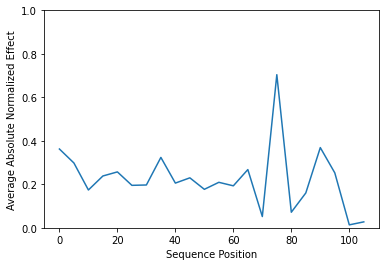

In [85]:
# plot effect
plt.plot(range(0, 110, 5), average_normalized_effect)
plt.ylabel('Average Absolute Normalized Effect')
plt.xlabel('Sequence Position')
plt.ylim((0, 1)) 
plt.savefig('avg_norm_effect_plot_.png')
plt.show()


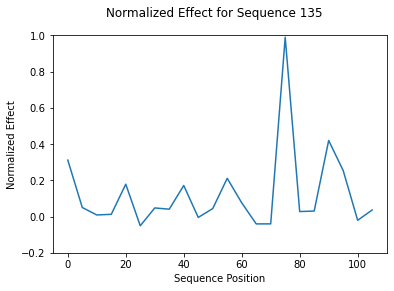

In [86]:
seq = 135
plt.plot(range(0, 110, 5), normalized_effects[seq])
plt.ylabel('Normalized Effect')
plt.xlabel('Sequence Position')
plt.suptitle('Normalized Effect for Sequence ' + str(seq))
plt.ylim((-.2, 1)) 
plt.savefig('norm_effect_plot_' + str(seq) + '.png')
plt.show()

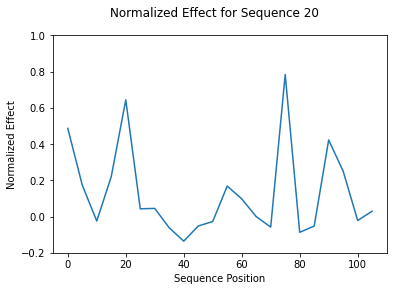

In [87]:
seq = 20
plt.plot(range(0, 110, 5), normalized_effects[seq])
plt.ylabel('Normalized Effect')
plt.xlabel('Sequence Position')
plt.ylim((-.2, 1)) 
plt.suptitle('Normalized Effect for Sequence ' + str(seq))
plt.savefig('norm_effect_plot_' + str(seq) + '.png')
plt.show()

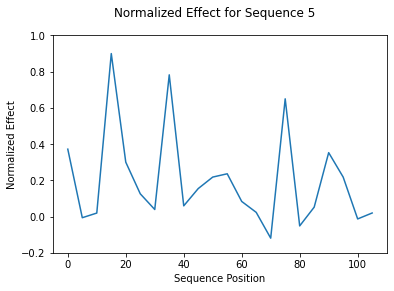

In [88]:
seq = 5
plt.plot(range(0, 110, 5), normalized_effects[seq])
plt.ylabel('Normalized Effect')
plt.xlabel('Sequence Position')
plt.ylim((-.2, 1)) 
plt.suptitle('Normalized Effect for Sequence ' + str(seq))
plt.savefig(v)
plt.show()